<a href="https://colab.research.google.com/github/heegeunyoon/python101/blob/main/4_1_over-fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [2]:
# 데이터 및 git repository 다운로드
![ ! -d python101 ] && git clone https://github.com/heegeunyoon/python101.git

Cloning into 'python101'...
remote: Enumerating objects: 1240, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1240 (delta 223), reused 150 (delta 150), pack-reused 965 (from 2)
Receiving objects: 100% (1240/1240), 120.82 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (648/648), done.
Updating files: 100% (77/77), done.


In [33]:
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline


# Deprecated
def load_boston_df():
  from sklearn.datasets import load_boston
  # boston 데이타셋 로드
  boston = load_boston()

  # boston 데이타셋 DataFrame 변환
  bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

  # boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함.
  bostonDF['MEDV'] = boston.target


# 파일에서 불러오기
bostonDF = pd.read_csv('/content/python101/input/BostonHousing.csv')
bostonDF.columns = ['CRIM', 'ZN', 'INDUS',	'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* INDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

- 데이터의 기본적인 특성 확인

In [34]:
bostonDF.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


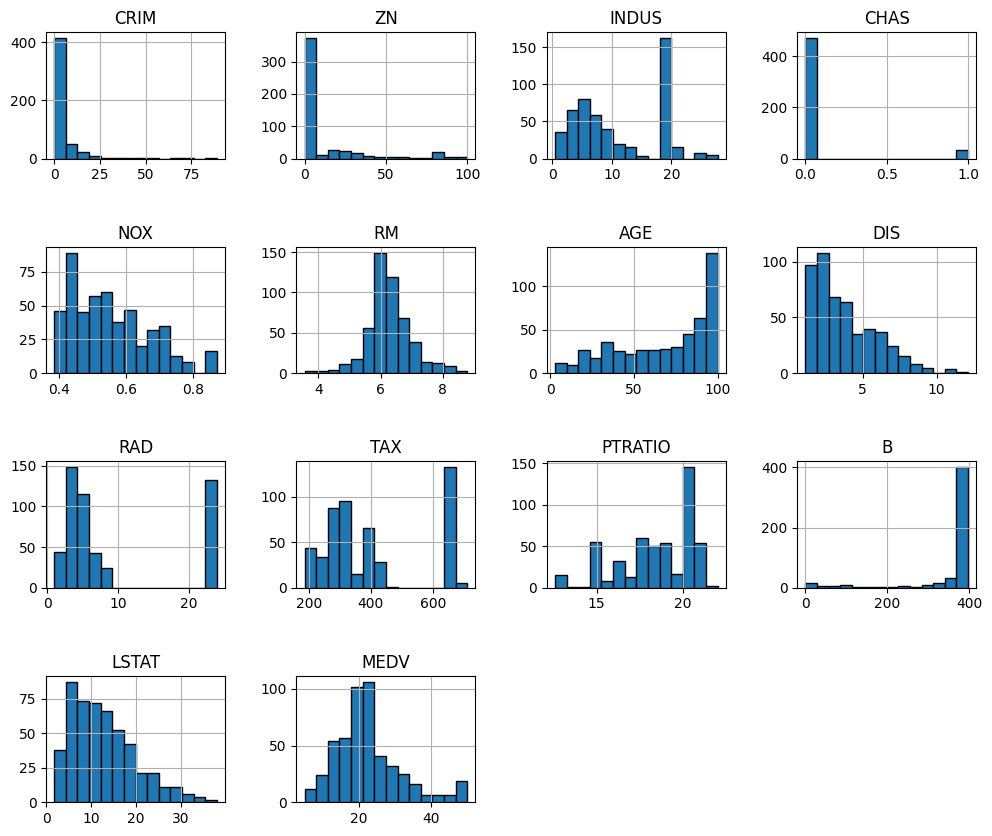

In [35]:
import matplotlib.pyplot as plt

bostonDF.hist(figsize=(12, 10), bins=14, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

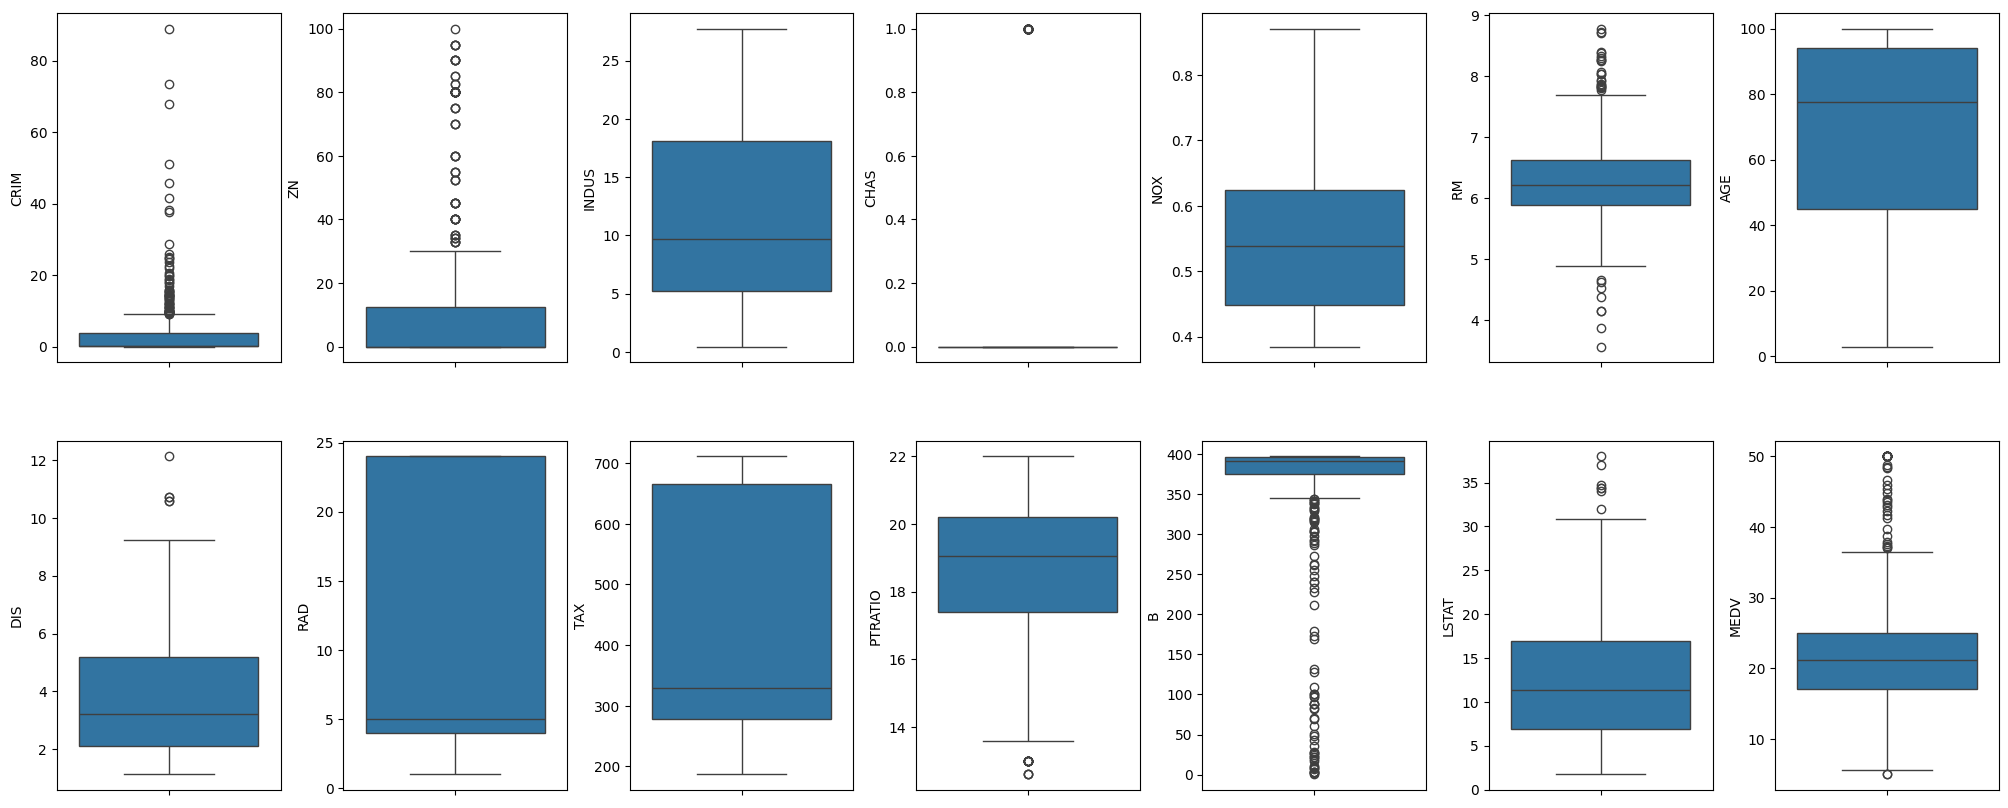

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 8))
index = 0
axs = axs.flatten()
for k,v in bostonDF.items():
    sns.boxplot(y=k, data=bostonDF, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사

<Axes: >

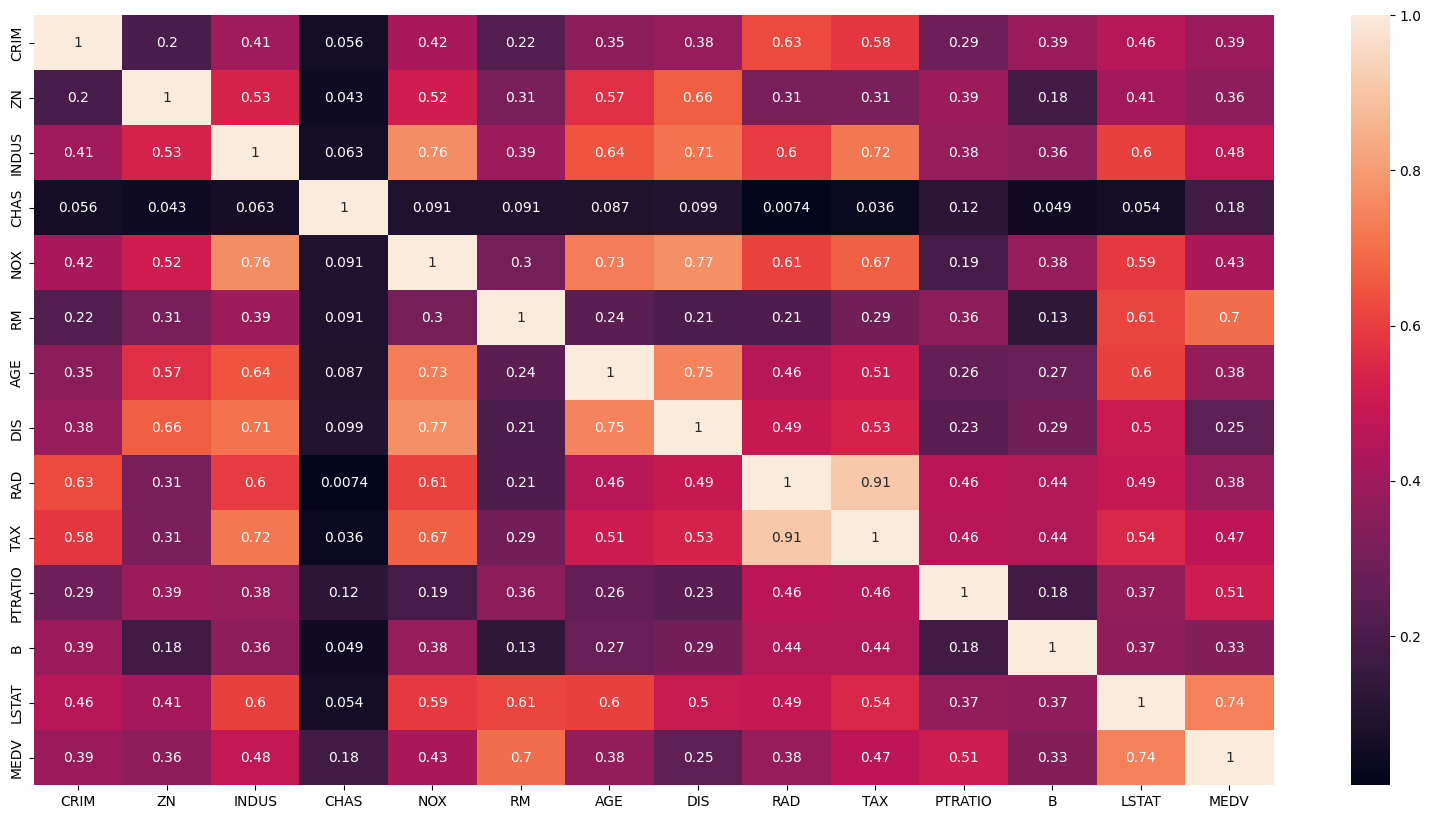

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(bostonDF.corr().abs(),  annot=True)

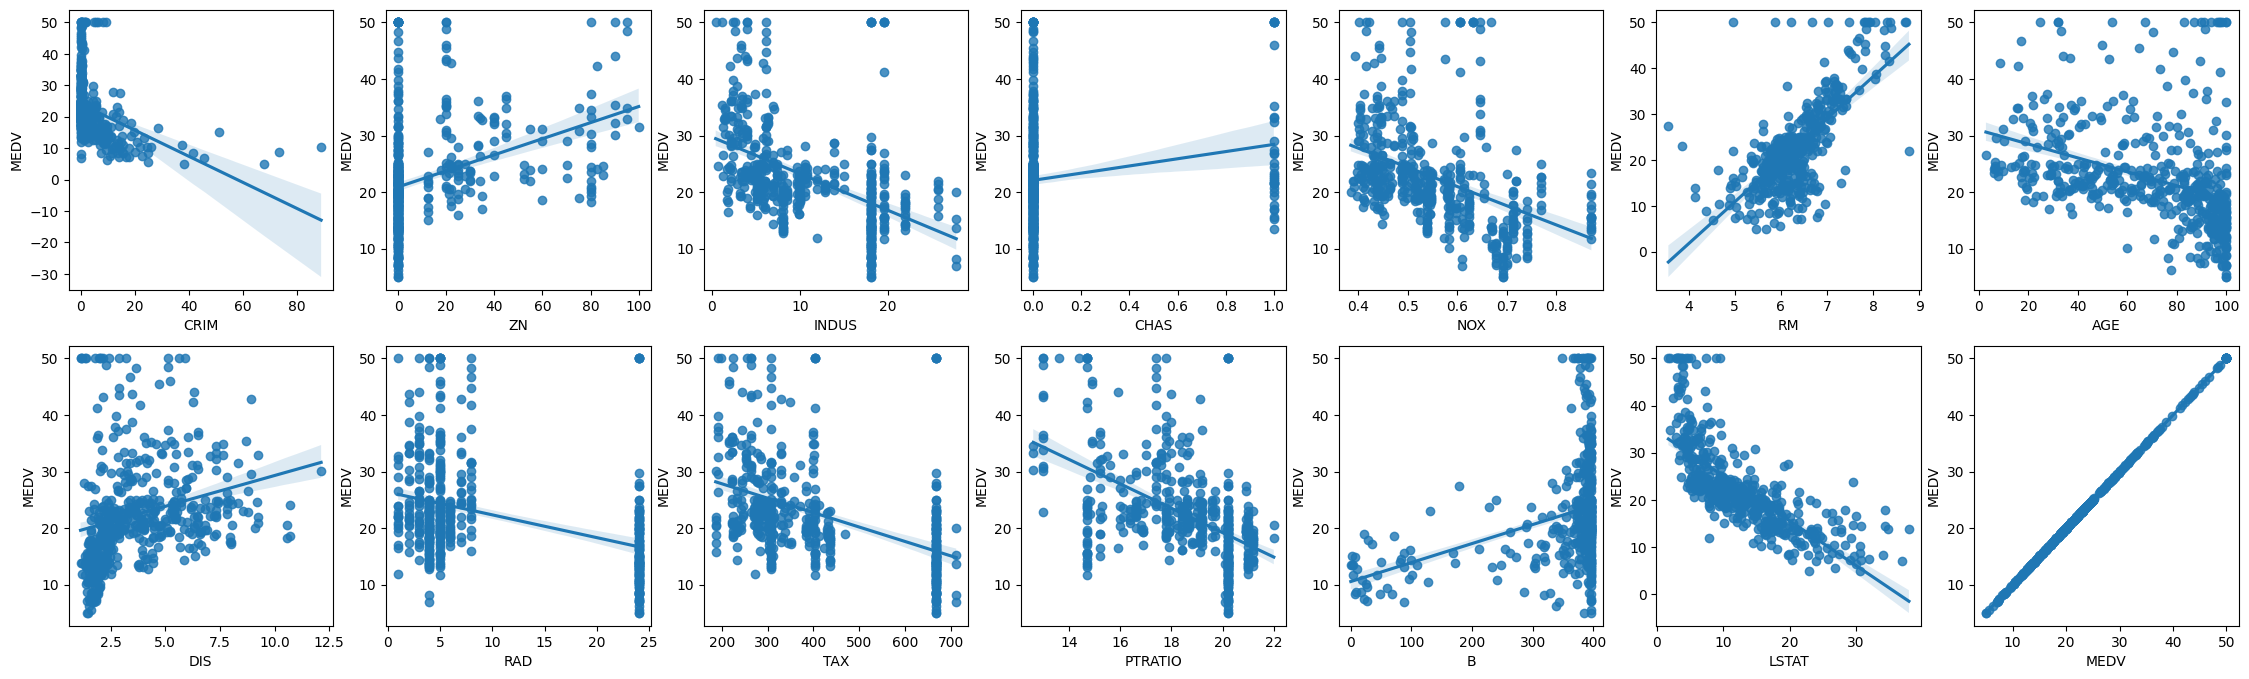

In [37]:
# 2개의 행과 7개의 열을 가진 subplots를 이용. axs는 7x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(28,8) , ncols=7, nrows=2)

for i , feature in enumerate(bostonDF.columns):
    row = int(i / 7)
    col = i % 7

    # seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    sns.regplot(x=feature, y='MEDV', data=bostonDF, ax=axs[row][col], order=1)#, logx=True)

fig1 = plt.gcf()
fig1.savefig('p322_boston.tif', format='tif', dpi=300, bbox_inches='tight')

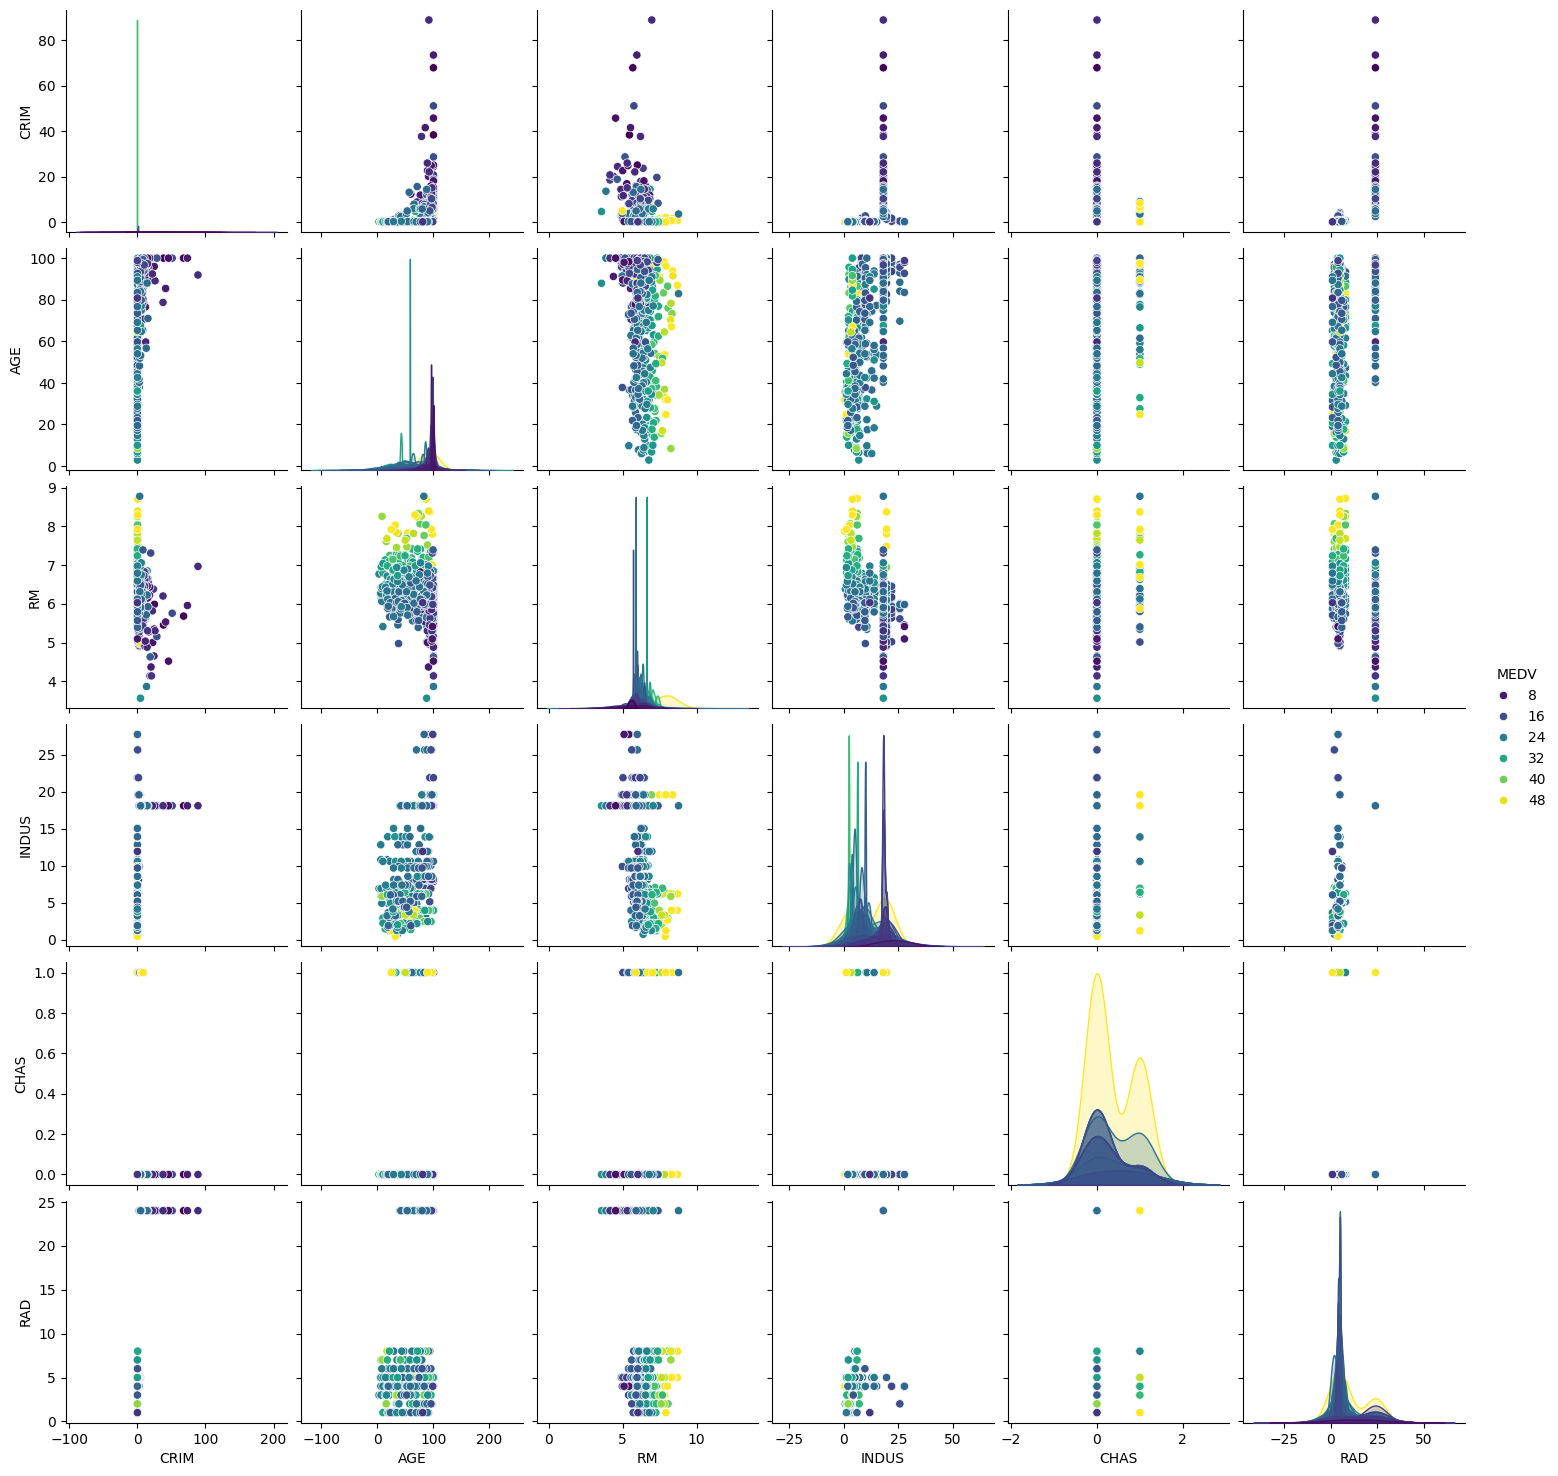

In [41]:
sub_columns = ["CRIM", "AGE", "RM", "INDUS", "CHAS", "RAD"]
subset = bostonDF[sub_columns + ["MEDV"]]
_ = sns.pairplot(data=subset, hue="MEDV", palette="viridis")

**학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['MEDV']
X_data = bostonDF.drop(['MEDV'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [43]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [44]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

,0
RM,3.4
CHAS,3.0
RAD,0.4
ZN,0.1
INDUS,0.0
B,0.0
TAX,-0.0
AGE,0.0
CRIM,-0.1
LSTAT,-0.6


In [46]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['MEDV']
X_data = bostonDF.drop(['MEDV'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


## Polynomial Regression과 오버피팅/언더피팅 이해
### Polynomial Regression 이해

PolynomialFeatures 클래스로 다항식 변환

![](https://github.com/minyoung347/python101/blob/main/image02.png?raw=1)

In [47]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X )

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature:\n', poly_ftr)


일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


3차 다항식 결정값을 구하는 함수 polynomial_func(X) 생성. 즉 회귀식은 결정값 y = 1+ 2x_1 + 3x_1^2 + 4x_2^3

In [48]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    print(X[:, 0])
    print(X[:, 1])
    return y

X = np.arange(0,4).reshape(2,2)

print('일차 단항식 계수 feature: \n' ,X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
[0 2]
[1 3]
삼차 다항식 결정값: 
 [  5 125]


3차 다항식 계수의 피처값과 3차 다항식 결정값으로 학습

In [49]:
from sklearn.linear_model import LinearRegression

# 3 차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n',poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr,y)
print('Polynomial 회귀 계수\n' , np.round(model.coef_, 2))
print('Polynomial 회귀 Shape :', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


**사이킷런 파이프라인(Pipeline)을 이용하여 3차 다항회귀 학습**  

사이킷런의 Pipeline 객체는 Feature 엔지니어링 변환과 모델 학습/예측을 순차적으로 결합

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

# Pipeline 객체로 Streamline 하게 Polynomial Feature변환과 Linear Regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])
X = np.arange(4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X, y)
print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))


Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


### 다항 회귀를 이용한 과소적합 및 과적합 이해

**cosine 곡선에 약간의 Noise 변동값을 더하여 실제값 곡선을 만듬**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환.
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터입니다.
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y 값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값입니다.
y = true_fun(X) + np.random.randn(n_samples) * 0.1

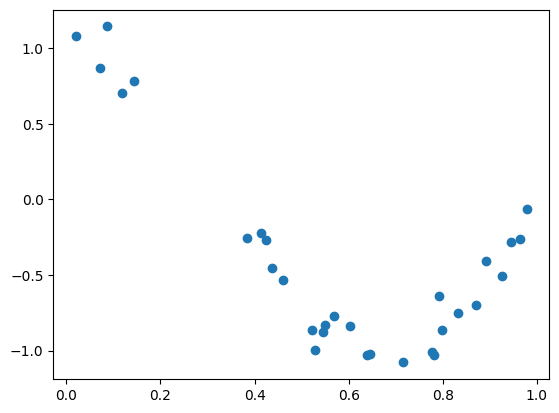

In [ ]:
plt.scatter(X, y)


Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE 는 0.4077289625098685 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE 는 0.04320874987232064 입니다.

Degree 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다.
Degree 15 MSE 는 181238256.56423894 입니다.


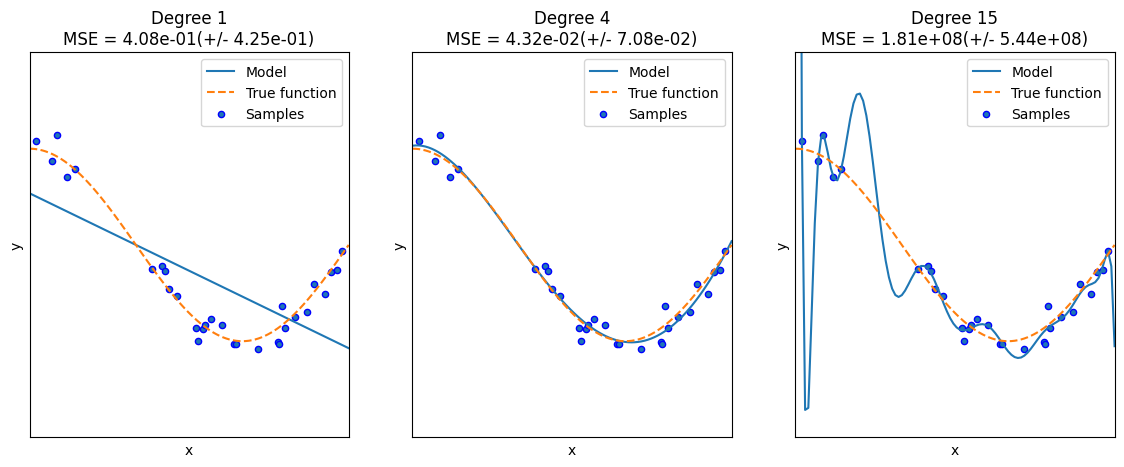

In [ ]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교합니다.
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    # 개별 degree별로 Polynomial 변환합니다.
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)

    # 교차 검증으로 다항 회귀를 평가합니다.
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring="neg_mean_squared_error", cv=10)

    # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {0} MSE 는 {1} 입니다.'.format(degrees[i], -1*np.mean(scores)))

    # 0 부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행합니다.
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교합니다.
    X_test = np.linspace(0, 1, 100)

    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")

    # 실제 값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()

## Regularized Linear Models – Ridge, Lasso
### Regularized Linear Model - Ridge Regression

In [ ]:
import pandas as pd

bostonDF = pd.read_csv('/content/python101/input/BostonHousing.csv')
bostonDF.columns = ['CRIM', 'ZN', 'INDUS',	'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']

In [ ]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이타셋 로드
# boston = load_boston()

# boston 데이타셋 DataFrame 변환
# bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함.
# bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


**alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE 측정**

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


**각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성**

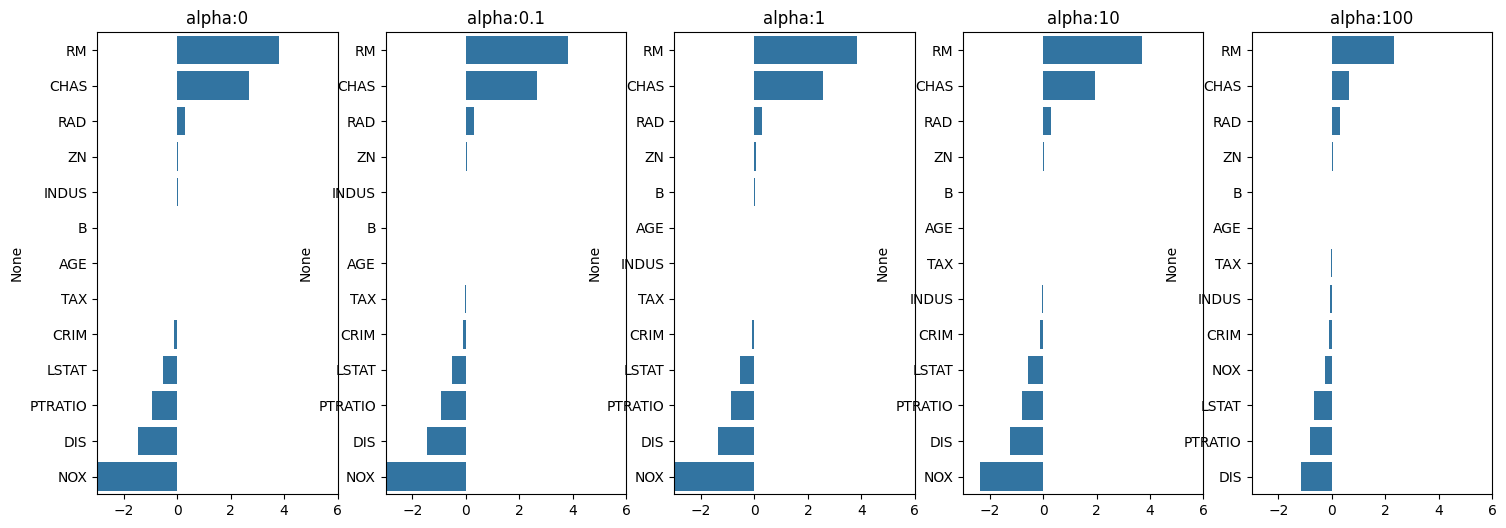

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

**alpha 값에 따른 컬럼별 회귀계수 출력**

In [ ]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### 라쏘 회귀

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [ ]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### 엘라스틱넷 회귀

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### 선형 회귀 모델을 위한 데이터 변환

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                         include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS